# Определение возраста покупателей 🍷

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;

- Контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.



**Этапы исследования:**

1. Первичный анализ исходных данных;

2. Обучение модели;

3. Выводы по проведенному исследованию;

**Техническое задание**

- Разработать нейросетевую модель. Получить значение метрики <tt>MAE</tt> на тестовой выборке не более <tt>8</tt>.

## Обзор данных 👨🏻‍🔬

### Используемые библиотеки

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import warnings


warnings.filterwarnings('ignore')

### Загрузка данных

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
datagen = ImageDataGenerator(rescale=1./255)
gen_flow = datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    seed=42)

Found 7591 validated image filenames.


### Информация о данных

Данные загружены с помощью `ImageDataGenerator`.

Посмотрим на то, с чем мы имеем дело, чуть подробнее

Для начала оценим общую информацию о данных:

In [3]:
display(labels.info())
display(labels.describe().T)
display(labels.shape)
labels.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


None

,count,mean,std,min,25%,50%,75%,max
real_age,7591.0,31.201159,17.14506,1.0,20.0,29.0,41.0,100.0


(7591, 2)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


7.5к размеченных фотографий. Пропусков нет. Целевая аудитория для нашего алгоритма (ребята до 18-ти лет) в нашей выборке присутствует. Отлично.

Но что же это за фото такие? Нужно воочию на них посмотреть.

Возьмем первый батч и разделим его на фичи (сами фотографии) и таргет (целевое значение возраста человека на фото):

In [4]:
X, y = next(gen_flow)

X.shape

(32, 224, 224, 3)

Признаки - это четырехмерный тензор. Батч состоит из 32 RGB-изображений размером 224х224 пикселя.

---

А затем воспользоваться нехитрым кодом построения таблицы графиков с фотографиями:

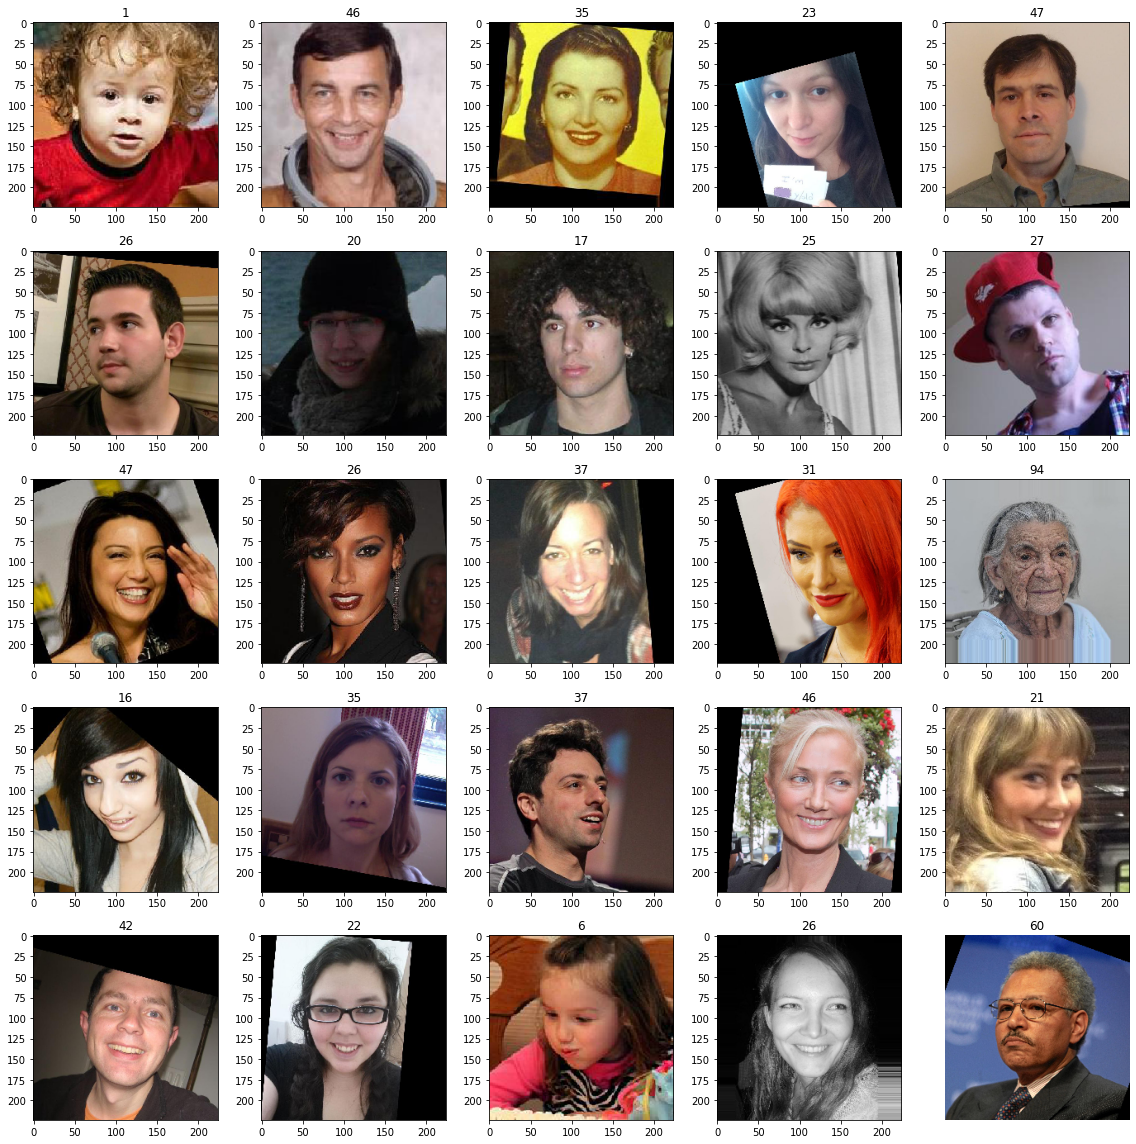

In [5]:
fig = plt.figure(figsize=(16, 16))
for i in range(25):
    fig.add_subplot(5, 5, i + 1)
    plt.imshow(X[i])
    plt.title(y[i])
    
    plt.axis('off')
plt.tight_layout()

Красавцы!) Пятое изображение в 4-ом ряду тому подтверждение.

Но нас сейчас должна интересовать ли внешняя притягательность тех или иных лиц, а все же качество разметки данных. И оно выглядит вполне достоверно!

Помимо качества разметки хочется отметить и то, что некоторые фото сделаны не в профиль, а под некоторыми углами или вовсе обрезаны. Но цетрирование по лицу вероятнее всего все же присутствует, что хорошо. Будем надеяться, что такая особенность в данных не сильно повлияет на конечное качество предсказаний. Изменять фотографии пока не будем.

___

Еще было бы интересно наглядно посмотреть на распределение возрастов в данных, так как было бы не слишком классно, если бы модель переобучилась на фотографиях старых людей и причисляла бы всем почетные 65 лет. Ну хоть пенсию бы начали платить, уже неплохо. Так, или пенсия уже с 70?)

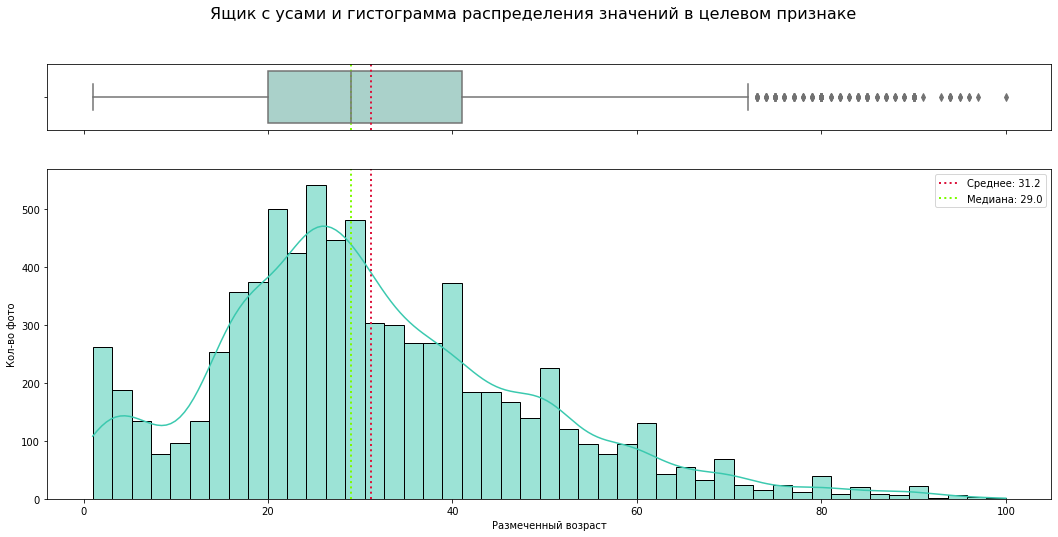

In [6]:
fig, (ax_boxplot, ax_histplot) = plt.subplots(2, figsize=(18, 8), sharex=True, 
                                              gridspec_kw= {"height_ratios": (0.2, 1)})

fig.suptitle('Ящик с усами и гистограмма распределения значений в целевом признаке', fontsize=16)

sns.boxplot(x=labels.real_age,
            ax=ax_boxplot,
            color='#a4d7ce')

ax_boxplot.set(xlabel='')

sns.histplot(x=labels.real_age,
             color='#3bc9af',
             kde=True)



ax_boxplot.axvline(labels.real_age.mean(), 
                    color='#DC143C', 
                    linestyle=':', 
                    linewidth=2, 
                    label=f'Среднее: {np.round(labels.real_age.mean(), 1)}')

ax_boxplot.axvline(labels.real_age.median(), 
                    color='#7CFC00', 
                    linestyle=':', 
                    linewidth=2, 
                    label=f'Медиана: {np.round(labels.real_age.median(), 1)}')


ax_histplot.axvline(labels.real_age.mean(), 
                    color='#DC143C', 
                    linestyle=':', 
                    linewidth=2, 
                    label=f'Среднее: {np.round(labels.real_age.mean(), 1)}')

ax_histplot.axvline(labels.real_age.median(), 
                    color='#7CFC00', 
                    linestyle=':', 
                    linewidth=2, 
                    label=f'Медиана: {np.round(labels.real_age.median(), 1)}')


ax_histplot.legend()
ax_histplot.set_ylabel('Кол-во фото')
ax_histplot.set_xlabel('Размеченный возраст')

plt.show()

Большая часть людей на фото достигли совершеннолетия, однако нельзя не отметить вот что: на отметках, кратных 10-ти, есть явно выделяющиеся пики, которые, вероятно, свидетельствуют о том, что некоторые фото были размечены "на глаз", поэтому целевые значения просто округлили до ближайшего числа, кратное 10-ти.

В остальном все, как и нужно: медиана и среднее как раз свидетельствуют о том, в какой момент жизни чаще всего люди потребляют большое кол-во алкоголя) Нашей модели такие претенденты только кстати)

<div style="border: 3px solid rgb(0,0,0); padding: 20px">

### Итого

- Импортированы библиотеки;
- Данные были загружены. Для формирования батчей с изображениями применили `ImageDataGenerator`;
- Изучена информация о данных;
- Рассмотрено визуальное содержание первых 25 изображений из первого батча; 
- Оценено распределение значений целевого признака.
    
</div>

## Обучение модели 🦾

Код в данном разделе был запущен на отдельном сервере с мощной GPU для ускорения вычислений при обучении нейросетевой модели, поэтому представлен он в ячейке Markdown:

<div style="border: 3px solid rgb(194, 194, 194); padding: 20px">

### Code

```python
import pandas as pd
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50 


def load_train(path):
    labels = pd.read_csv(f'{path}labels.csv')
    
    datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rotation_range=15,                               
        rescale=1/255)
    
    gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=f'{path}/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=42)

    return gen_flow

def load_test(path):
    labels = pd.read_csv(f'{path}labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255)
    
    gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=f'{path}/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=42)

    return gen_flow

def create_model(input_shape):

    model = Sequential([
        ResNet50(
            weights='imagenet', 
            input_shape=input_shape, 
            include_top=False),
        GlobalAveragePooling2D(),
        Dropout(0.1),
        Dense(1, activation='elu')
    ])
    
    optimizer=Adam(lr=1e-4)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=15,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```
    
</div>

<div style="border: 3px solid rgb(123, 6, 6); padding: 20px">

### Output

```
Train for 178 steps, validate for 60 steps

Epoch 1/15

178/178 - 106s - loss: 249.8861 - mae: 11.2475 - val_loss: 695.2338 - val_mae: 21.2967

Epoch 2/15

178/178 - 98s - loss: 89.9037 - mae: 7.1245 - val_loss: 578.1782 - val_mae: 18.7473

Epoch 3/15

178/178 - 98s - loss: 66.6416 - mae: 6.1771 - val_loss: 221.7371 - val_mae: 11.2443

Epoch 4/15

178/178 - 97s - loss: 52.2916 - mae: 5.5058 - val_loss: 111.9495 - val_mae: 8.1263

Epoch 5/15

178/178 - 97s - loss: 44.7888 - mae: 5.1199 - val_loss: 80.0853 - val_mae: 6.7450

Epoch 6/15

178/178 - 98s - loss: 37.0369 - mae: 4.6352 - val_loss: 90.6838 - val_mae: 7.0644

Epoch 7/15
    
178/178 - 97s - loss: 32.5034 - mae: 4.3586 - val_loss: 85.1492 - val_mae: 7.0931

Epoch 8/15

178/178 - 97s - loss: 27.7409 - mae: 4.0686 - val_loss: 102.5931 - val_mae: 7.4163

Epoch 9/15

178/178 - 98s - loss: 24.0523 - mae: 3.7672 - val_loss: 79.0263 - val_mae: 6.7287

Epoch 10/15

178/178 - 96s - loss: 22.3232 - mae: 3.6237 - val_loss: 71.4517 - val_mae: 6.2084

Epoch 11/15

178/178 - 97s - loss: 19.6441 - mae: 3.4166 - val_loss: 70.0770 - val_mae: 6.1871

Epoch 12/15

178/178 - 93s - loss: 16.7231 - mae: 3.1418 - val_loss: 67.2167 - val_mae: 5.9572

Epoch 13/15

178/178 - 91s - loss: 14.6926 - mae: 2.9199 - val_loss: 63.1234 - val_mae: 5.9188

Epoch 14/15

178/178 - 97s - loss: 13.2552 - mae: 2.7937 - val_loss: 62.7690 - val_mae: 5.7293

Epoch 15/15

178/178 - 96s - loss: 11.8983 - mae: 2.6410 - val_loss: 66.4475 - val_mae: 6.0589
    

60/60 - 10s - loss: 66.4475 - mae: 6.0589

Test MAE: 6.0589

```
    
</div>

<div style="border: 3px solid rgb(0,0,0); padding: 20px">

### Итого

По оконачании процесса обучения вышеописанной модели получили значение <tt>MAE</tt> равное <tt>6.05</tt>, что является потрясающим результатом и с неплохим запасом подходит под условия исходной задачи: 
    
- Получить значение метрики <tt>MAE</tt> на тестовой выборке не более <tt>8</tt>.
    
</div>

## Общий вывод 👀

<div style="border: 3px solid rgb(119,212,150); padding: 20px">

Для супермаркета с довольно "вкусным" названием "Хлеб-соль" требовалось разработать нейросетевую модель для определения возраста клиентов по их фотографии. С данной задачей (с учетом технических требований) мы справились отлично.
    
### Краткая сводка по выполненным задачам
    
#### Шаг 1. Обзор данных

- Импортированы библиотеки;
- Данные были загружены. Для формирования батчей с изображениями применили `ImageDataGenerator`;
- Изучена информация о данных;
- Рассмотрено визуальное содержание первых 25 изображений из первого батча; 
- Оценено распределение значений целевого признака;
    
#### Шаг 2. Обучение модели
    
В качестве основной модели была выбрана модель <tt>ResNet50</tt>, предобученная на датасете изображений <tt>ImageNet</tt>. Для улучшения качества предсказаний к основным слоям модели были добавлены следующие:

- <tt>GlobalAveragePooling2D</tt>. Сверточный слой для уменьшения размера всего выходного тензора основной модели;
- <tt>Dropout</tt>. Слой для регуляризации, который уменьшает переобучение модели путем исключения сложных связей между нейронами предыдущих слоев сети.
- <tt>Dense</tt>. Финальный слой нейросетевой модели, использующий функцию активации <tt>ELU</tt>. Почему не ReLU? ReLU предобразовывает все полученные входные значения в 0, поэтому данные значения не берутся в учет в следующем слое, а ELU использует экспонециальную функцию для определения значений предыдущего слоя, которые равны нулю ⇒ больше значимых признаков для решения поставленной задачи получаем в итоге.

✅ На тестовой выборке значение <tt>MAE</tt> получилось равным <tt>6.05</tt>, что удовлетворяет техническому заданию заказчика.
</div>